# Gravity inversion with a model slice

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


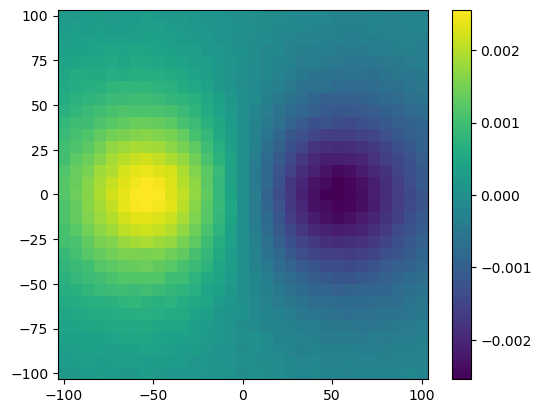

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
h = [(5.0, 40)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40       -100.00        100.00      5.00      5.00    1.00
   y     40       -100.00        100.00      5.00      5.00    1.00
   z     40       -200.00          0.00      5.00      5.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


/home/santi/.miniforge3/envs/inversion_ideas/lib/python3.13/site-packages/simpeg/utils/model_builder.py:37: BreakingChangeWarning: Since SimPEG v0.25.0, the 'get_indices_block' function returns a single array with the cell indices, instead of a tuple with a single element. This means that we don't need to unpack the tuple anymore to access to the cell indices.
If you were using this function as in:

    ind = get_indices_block(p0, p1, mesh.cell_centers)[0]

Make sure you update it to:

    ind = get_indices_block(p0, p1, mesh.cell_centers)

To hide this warning, add this to your script or notebook:

    import warnings
    from simpeg.utils import BreakingChangeWarning

    warnings.filterwarnings(action='ignore', category=BreakingChangeWarning)

  ind = get_indices_block(p0, p1, cell_centers)


(<matplotlib.collections.QuadMesh at 0x7f4532042ad0>,)

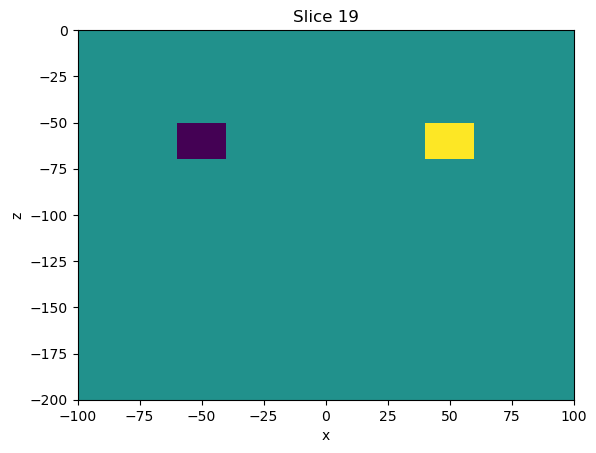

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

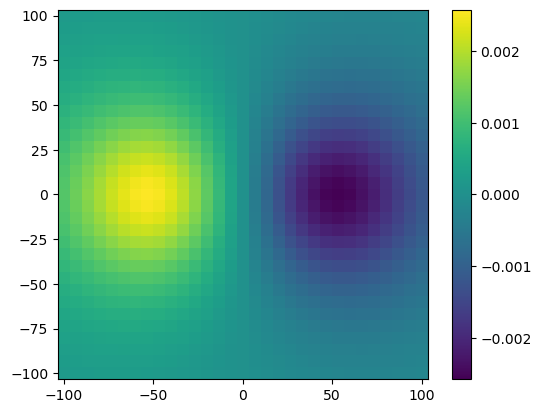

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Define inversion using the new framework

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)

In [15]:
dpred = simulation(model)

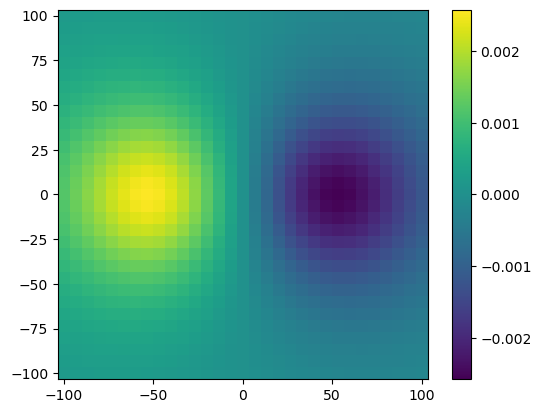

In [16]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [17]:
simulation.jacobian(model)

array([[-2.13782823e-05, -2.13372550e-05, -2.12555951e-05, ...,
        -1.03258138e-07, -9.94137181e-08, -9.57099928e-08],
       [-2.13691528e-05, -2.13828480e-05, -2.13554722e-05, ...,
        -1.08606834e-07, -1.04571292e-07, -1.00679443e-07],
       [-2.12872892e-05, -2.13554722e-05, -2.13828480e-05, ...,
        -1.14213826e-07, -1.09984235e-07, -1.05900419e-07],
       ...,
       [-4.40011354e-06, -4.50945208e-06, -4.62019534e-06, ...,
        -5.03316037e-02, -6.45257719e-03, -1.40158215e-03],
       [-4.25670714e-06, -4.36399932e-06, -4.47284401e-06, ...,
        -6.45257719e-03, -5.03316037e-02, -1.27241928e-02],
       [-4.11623023e-06, -4.22130506e-06, -4.32805791e-06, ...,
        -9.48031491e-04, -3.60945193e-03, -3.23499329e-02]],
      shape=(961, 64000))

Define a composed model: one part for densities, and another part for a dummy physical property.

Build initial model dictionary and use it to create wires:

In [18]:
initial_model_dict = {
    "density": np.zeros(simulation.n_params),
    "dummy": np.zeros(3),
}

wires = ii.Wires.create_from(initial_model_dict)

In [19]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation, model_slice=wires.density)

In [21]:
depth_weights = depth_weighting(mesh, 0) ** 2

# Let's use a tikhonov zero for now, because I haven't implemented model slices in Smallness yet
# smallness = ii.Smallness(mesh=mesh, cell_weights=depth_weights)

# I need to manually combine weights for the density and weights for the dummy (just zeros).
# This shouldn't be necessary if the regularization handles model slices too.
density_weights = mesh.cell_volumes * depth_weights
dummy_weights = np.zeros(wires.dummy.size)
weights = np.hstack((density_weights, dummy_weights))

smallness = ii.TikhonovZero(n_params=wires.size, weights=weights)

In [22]:
phi = data_misfit + 1e2 * smallness

Convert the initial model dict to array using the wires

In [23]:
initial_model = wires.dict_to_array(initial_model_dict)
initial_model

array([0., 0., 0., ..., 0., 0., 0.], shape=(64003,))

In [24]:
# Ignore preconditioner for now, the DataMisfit doesn't support it yet for model slices
# preconditioner = ii.get_jacobi_preconditioner(phi, initial_model)
# preconditioner

In [25]:
import time

start = time.time()
inverted_model = ii.conjugate_gradient(phi, initial_model, rtol=1e-6)
end = time.time()
print(f"Elapsed time (no preconditioner): {end - start:.2f}s")

Elapsed time (no preconditioner): 21.80s


In [26]:
inverted_model

array([-0.00012583, -0.0001243 , -0.00012219, ...,  0.        ,
        0.        ,  0.        ], shape=(64003,))

In [27]:
inverted_model_dict = wires.array_to_dict(inverted_model)
inverted_model_dict

{'density': array([-0.00012583, -0.0001243 , -0.00012219, ..., -0.00049973,
         0.0006469 , -0.00042525], shape=(64000,)),
 'dummy': array([0., 0., 0.])}

In [28]:
inverted_density = inverted_model_dict["density"]
inverted_density

array([-0.00012583, -0.0001243 , -0.00012219, ..., -0.00049973,
        0.0006469 , -0.00042525], shape=(64000,))

(<matplotlib.collections.QuadMesh at 0x7f45345f87d0>,)

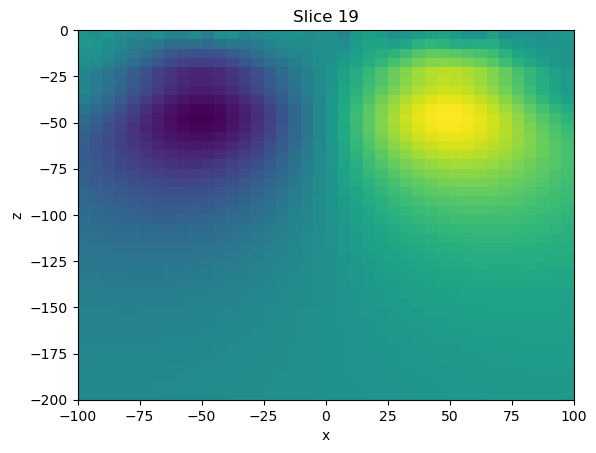

In [29]:
mesh.plot_slice(inverted_density, normal="Y", slice_loc=0)